In [1]:
import pandas as pd
import numpy as np 
import glob
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import PathPatch

In [2]:
def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [3]:
# fp_data = "/Users/christophermancuso/Desktop/project_data/cross_species/cross_species_tmp/metrics/"
fp_data = "../results/metrics/"
FNs1 = glob.glob(fp_data+"Metric*AllOnes*adj*.tsv")
FNs2 = glob.glob(fp_data+"Metric*SummedDegree-0.50*2000*0.1_0.001_120_8_10*.tsv")
FNs3 = glob.glob(fp_data+"Metric*AllOnes*2000*0.1_0.001_120_8_10*.tsv")
FNs = FNs1 + FNs2 + FNs3
df_results = pd.DataFrame()
for aFN in FNs:
    df_tmp = pd.read_csv(aFN,sep="\t")
    if df_tmp.shape[0] == 0:
        # this is for dr BioGRID where there are no terms
        continue
    # remove hs_mm that has AllOnes embeddings
    if ("AllOnes" in aFN) and ("hs_mm" in aFN) and ("Pecanpy" in aFN):
        continue
    GSCtmp = "_".join(df_tmp["GSC_info"].to_list()[0].split("__")[1].split("_")[0:2])
    df_tmp["GSC"] = [GSCtmp] * df_tmp.shape[0]
    df_results = pd.concat([df_results,df_tmp])
df_results.head()

,GSC_info,network,species,connections,feature_type,model_info,ID,name,num_train_pos,num_train_all,num_test_pos,num_test_all,avgp,log2p,auroc,PTopK,GSC
0,MethodNum-0__GO_mm_20_100_0.5_0.5,IMP_inf-0.8-trans,hs_mm,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0000041,transition metal ion transport,37,6141,12,3117,0.008175,1.086335,0.565781,0,GO_mm
1,MethodNum-0__GO_mm_20_100_0.5_0.5,IMP_inf-0.8-trans,hs_mm,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0000209,protein polyubiquitination,22,6112,19,3092,0.013992,1.187160,0.631373,0,GO_mm
2,MethodNum-0__GO_mm_20_100_0.5_0.5,IMP_inf-0.8-trans,hs_mm,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0000724,double-strand break repair via homologous reco...,14,5898,10,3035,0.031852,3.273073,0.853025,0,GO_mm
3,MethodNum-0__GO_mm_20_100_0.5_0.5,IMP_inf-0.8-trans,hs_mm,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0001578,microtubule bundle formation,15,6005,34,2988,0.064481,2.502510,0.800370,3,GO_mm
4,MethodNum-0__GO_mm_20_100_0.5_0.5,IMP_inf-0.8-trans,hs_mm,eggnog_direct_AllOnes,adj,NoScaling__LR_l2_1.0,GO:0001825,blastocyst formation,43,5865,13,3089,0.010738,1.351374,0.699510,0,GO_mm


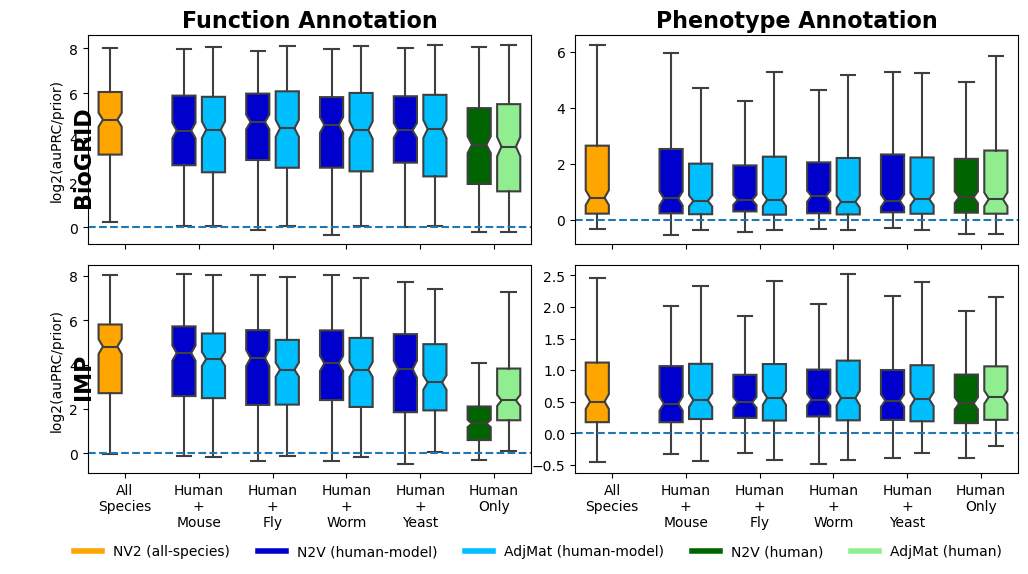

In [4]:
%%capture --no-display
def make_plots4():
    fig, ax = plt.subplots(2,2,figsize=(12,6))
    for idx2, anet in enumerate(["BioGRID_raw","IMP_raw"]):
        for idx1, aGSC in enumerate(["GO", "Monarch"]):
            df_tmp = df_results[(df_results["network"]==anet)&
                                (df_results["GSC"]==f"{aGSC}_hs")]
            species_tmp = df_tmp["species"].to_list()
            features_tmp = df_tmp["feature_type"].to_list()
            new_hue = []
            new_xlabel = []
            for idx, item in enumerate(species_tmp):
                if features_tmp[idx] == "adj":
                    new_hue.append("AdjMat")
                else:
                    new_hue.append("N2V")
                if "ce_dm" in item:
                    new_xlabel.append("All\nSpecies")
                elif "_" not in item:
                    new_xlabel.append("Human\nOnly")
                elif item == "ce_hs":
                    new_xlabel.append("Human\n+\nWorm")
                elif item == "dm_hs":
                    new_xlabel.append("Human\n+\nFly")
                elif item == "dr_hs":
                    new_xlabel.append("Human\n+\nFish")
                elif item == "hs_mm":
                    new_xlabel.append("Human\n+\nMouse")
                elif item == "hs_sc":
                    new_xlabel.append("Human\n+\nYeast")
            df_tmp["hue"] = new_hue
            df_tmp["xlabel"] = new_xlabel
            myorder = ["All\nSpecies","Human\n+\nMouse","Human\n+\nFly",
                       "Human\n+\nWorm","Human\n+\nYeast","Human\nOnly"]
            sns.boxplot(data=df_tmp,x="xlabel",y="log2p",hue="hue",
                        notch=True,showfliers=False,ax=ax[idx2,idx1],
                        order=myorder,
                        hue_order = ["N2V","AdjMat"])
            mycolors = ["orange"] + 4* ["mediumblue","deepskyblue"] + ["darkgreen","lightgreen"]
            box_patches = [patch for patch in ax[idx2,idx1].patches if type(patch) == matplotlib.patches.PathPatch]
            if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax2.artists
                box_patches = ax2.artists
            for anind, artist in enumerate(box_patches):
                artist.set_facecolor(mycolors[anind])
            ax[idx2,idx1].get_legend().remove()
            ax[idx2,idx1].set_xlabel("")
            ax[idx2,idx1].axhline(ls="--")
            if idx2 == 0:
                ax[idx2,idx1].set_xticklabels("")
            else:
                ax[idx2,idx1].set_xticklabels(ax[idx2,idx1].get_xticklabels(),fontsize=10)
            if idx1 == 1:
                ax[idx2,idx1].set_ylabel("")
            else:
                ax[idx2,idx1].set_ylabel("log2(auPRC/prior)",fontsize=10)
    ax[0,0].set_title("Function Annotation",fontsize=16,fontweight="bold")
    ax[0,1].set_title("Phenotype Annotation",fontsize=16,fontweight="bold")
    plt.annotate("BioGRID",xy=(0.06,0.62),xycoords="figure fraction",
                 rotation="vertical",fontsize=16,fontweight="bold")
    plt.annotate("IMP",xy=(0.06,0.30),xycoords="figure fraction",
                 rotation="vertical",fontsize=16,fontweight="bold")
    # make a legend
    handles = [Line2D([0], [0], color="orange", lw=4),
               Line2D([0], [0], color="mediumblue", lw=4),
               Line2D([0], [0], color="deepskyblue", lw=4),
               Line2D([0], [0], color="darkgreen", lw=4),
               Line2D([0], [0], color="lightgreen", lw=4)]
    labels = ["NV2 (all-species)","N2V (human-model)", "AdjMat (human-model)",
              "N2V (human)", "AdjMat (human)"]
    plt.subplots_adjust(bottom=0.15,hspace=0.1,wspace=0.1)
    fig.legend(handles, labels, ncol=5, loc = 10, bbox_to_anchor=(0.5, 0.02), \
        frameon=False, fontsize=10)
    adjust_box_widths(fig, 0.8)
    fig.savefig('../figures/Fig2.pdf')
make_plots4()